In [15]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory


import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/glove6b/glove.6B.200d.txt
/kaggle/input/glove6b/glove.6B.50d.txt
/kaggle/input/glove6b/glove.6B.300d.txt
/kaggle/input/glove6b/glove.6B.100d.txt
/kaggle/input/tensorflow2-question-answering/simplified-nq-train.jsonl
/kaggle/input/tensorflow2-question-answering/sample_submission.csv
/kaggle/input/tensorflow2-question-answering/simplified-nq-test.jsonl


In [16]:
#import necessary libraries
import numpy as np 
import pandas as pd
import json
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import re
import gc
import seaborn as sns

import tensorflow as tf
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer

from tensorflow.keras.layers import LSTM, Bidirectional, GlobalMaxPooling1D, SpatialDropout1D, Dense, Dropout, Input, concatenate, Conv1D, Activation, Flatten

In [17]:
sample_submission = pd.read_csv("../input/tensorflow2-question-answering/sample_submission.csv")
sample_submission.head(20)

,example_id,PredictionString
0,-1011141123527297803_long,NaN
1,-1011141123527297803_short,NaN
2,-1028916936938579349_long,NaN
3,-1028916936938579349_short,NaN
4,-1055197305756217938_long,NaN
5,-1055197305756217938_short,NaN
6,-1074129516932871805_long,NaN
7,-1074129516932871805_short,NaN
8,-1114334749483663139_long,NaN
9,-1114334749483663139_short,NaN


In [18]:
#path for data files
train_path = '../input/tensorflow2-question-answering/simplified-nq-train.jsonl'
test_path = '../input/tensorflow2-question-answering/simplified-nq-test.jsonl'

In [19]:
chunksize=2000

In [20]:
#read a sample of data files
def read_data(path, sample = True, chunksize = chunksize):
    if sample == True:
        df = []
        with open(path, 'r') as reader:
            for i in range(chunksize):
                df.append(json.loads(reader.readline()))
        df = pd.DataFrame(df)
        print('Sample data have {} rows and {} columns'.format(df.shape[0], df.shape[1]))
    else:
        df = pd.read_json(path, orient = 'records', lines = True)
        print('Sample data have {} rows and {} columns'.format(df.shape[0], df.shape[1]))
        gc.collect()
    return df

train = read_data(train_path, sample = True)
test = read_data(test_path, sample = False)
train.head()

Sample data have 2000 rows and 6 columns
Sample data have 346 rows and 4 columns


,document_text,long_answer_candidates,question_text,annotations,document_url,example_id
0,Email marketing - Wikipedia <H1> Email marketi...,"[{'start_token': 14, 'top_level': True, 'end_t...",which is the most common use of opt-in e-mail ...,"[{'yes_no_answer': 'NONE', 'long_answer': {'st...",https://en.wikipedia.org//w/index.php?title=Em...,5655493461695504401
1,The Mother ( How I Met Your Mother ) - wikiped...,"[{'start_token': 28, 'top_level': True, 'end_t...",how i.met your mother who is the mother,"[{'yes_no_answer': 'NONE', 'long_answer': {'st...",https://en.wikipedia.org//w/index.php?title=Th...,5328212470870865242
2,Human fertilization - wikipedia <H1> Human fer...,"[{'start_token': 14, 'top_level': True, 'end_t...",what type of fertilisation takes place in humans,"[{'yes_no_answer': 'NONE', 'long_answer': {'st...",https://en.wikipedia.org//w/index.php?title=Hu...,4435104480114867852
3,List of National Football League career quarte...,"[{'start_token': 28, 'top_level': True, 'end_t...",who had the most wins in the nfl,"[{'yes_no_answer': 'NONE', 'long_answer': {'st...",https://en.wikipedia.org//w/index.php?title=Li...,5289242154789678439
4,Roanoke Colony - wikipedia <H1> Roanoke Colony...,"[{'start_token': 32, 'top_level': True, 'end_t...",what happened to the lost settlement of roanoke,"[{'yes_no_answer': 'NONE', 'long_answer': {'st...",https://en.wikipedia.org//w/index.php?title=Ro...,5489863933082811018


# Exploratory Data Analysis

In [21]:
df = read_data(train_path, sample = True)
print(df['question_text'][1])
print(df['annotations'][1])

Sample data have 2000 rows and 6 columns
how i.met your mother who is the mother
[{'yes_no_answer': 'NONE', 'long_answer': {'start_token': 212, 'candidate_index': 15, 'end_token': 310}, 'short_answers': [{'start_token': 213, 'end_token': 215}], 'annotation_id': 12034874153783787365}]


Text(0.5, 1.0, 'Distribution of text word count of 2000 documents')

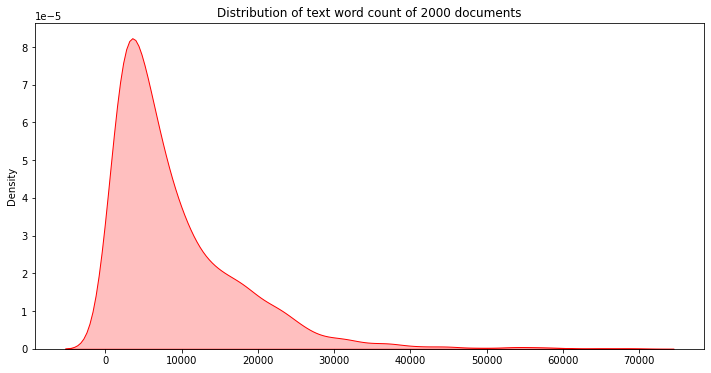

In [22]:
#check the distribution of word count in sample 10000 documents
doc_text_words = df['document_text'].apply(lambda x: len(x.split(' ')))
plt.figure(figsize=(12,6))
sns.kdeplot(doc_text_words.values,shade=True, color="r").set_title('Distribution of text word count of ' + str(chunksize) + ' documents')

In [24]:
#long_answer_candidates
df.long_answer_candidates[0][:5]

[{'start_token': 14, 'top_level': True, 'end_token': 170},
 {'start_token': 15, 'top_level': False, 'end_token': 169},
 {'start_token': 52, 'top_level': False, 'end_token': 103},
 {'start_token': 53, 'top_level': False, 'end_token': 102},
 {'start_token': 103, 'top_level': False, 'end_token': 156}]

In [23]:
df.annotations[1][:100]

[{'yes_no_answer': 'NONE',
  'long_answer': {'start_token': 212, 'candidate_index': 15, 'end_token': 310},
  'short_answers': [{'start_token': 213, 'end_token': 215}],
  'annotation_id': 12034874153783787365}]

In [25]:
df.question_text[1][:100]

'how i.met your mother who is the mother'

In [26]:
df.document_text[3][:100]

'List of National Football League career quarterback wins leaders - wikipedia <H1> List of National F'

In [28]:
#check long_answers_distribution
def preprocess_data():
    df = read_data(train_path, sample = True)
    df['yes_no'] = df.annotations.apply(lambda x: x[0]['yes_no_answer'])
    df['long'] = df.annotations.apply(lambda x: [x[0]['long_answer']['start_token'], x[0]['long_answer']['end_token']])
    df['short'] = df.annotations.apply(lambda x: x[0]['short_answers'])
    return df
df = preprocess_data()
df

Sample data have 2000 rows and 6 columns


,document_text,long_answer_candidates,question_text,annotations,document_url,example_id,yes_no,long,short
0,Email marketing - Wikipedia <H1> Email marketi...,"[{'start_token': 14, 'top_level': True, 'end_t...",which is the most common use of opt-in e-mail ...,"[{'yes_no_answer': 'NONE', 'long_answer': {'st...",https://en.wikipedia.org//w/index.php?title=Em...,5655493461695504401,NONE,"[1952, 2019]","[{'start_token': 1960, 'end_token': 1969}]"
1,The Mother ( How I Met Your Mother ) - wikiped...,"[{'start_token': 28, 'top_level': True, 'end_t...",how i.met your mother who is the mother,"[{'yes_no_answer': 'NONE', 'long_answer': {'st...",https://en.wikipedia.org//w/index.php?title=Th...,5328212470870865242,NONE,"[212, 310]","[{'start_token': 213, 'end_token': 215}]"
2,Human fertilization - wikipedia <H1> Human fer...,"[{'start_token': 14, 'top_level': True, 'end_t...",what type of fertilisation takes place in humans,"[{'yes_no_answer': 'NONE', 'long_answer': {'st...",https://en.wikipedia.org//w/index.php?title=Hu...,4435104480114867852,NONE,"[319, 438]",[]
3,List of National Football League career quarte...,"[{'start_token': 28, 'top_level': True, 'end_t...",who had the most wins in the nfl,"[{'yes_no_answer': 'NONE', 'long_answer': {'st...",https://en.wikipedia.org//w/index.php?title=Li...,5289242154789678439,NONE,"[509, 576]","[{'start_token': 512, 'end_token': 514}]"
4,Roanoke Colony - wikipedia <H1> Roanoke Colony...,"[{'start_token': 32, 'top_level': True, 'end_t...",what happened to the lost settlement of roanoke,"[{'yes_no_answer': 'NONE', 'long_answer': {'st...",https://en.wikipedia.org//w/index.php?title=Ro...,5489863933082811018,NONE,"[-1, -1]",[]
...,...,...,...,...,...,...,...,...,...
1995,Grace and Frankie - Wikipedia <H1> Grace and F...,"[{'start_token': 10, 'top_level': True, 'end_t...",how long is each grace and frankie episode,"[{'yes_no_answer': 'NONE', 'long_answer': {'st...",https://en.wikipedia.org//w/index.php?title=Gr...,-7716384782891686197,NONE,"[10, 399]","[{'start_token': 300, 'end_token': 304}]"
1996,Cellular respiration - wikipedia <H1> Cellular...,"[{'start_token': 10, 'top_level': True, 'end_t...",after complete oxidation of a glucose molecule...,"[{'yes_no_answer': 'NONE', 'long_answer': {'st...",https://en.wikipedia.org//w/index.php?title=Ce...,8933277615800380148,NONE,"[780, 883]","[{'start_token': 796, 'end_token': 799}]"
1997,Some Like It Hot ( song ) - wikipedia <H1> Som...,"[{'start_token': 18, 'top_level': True, 'end_t...",who sings the song some like it hot,"[{'yes_no_answer': 'NONE', 'long_answer': {'st...",https://en.wikipedia.org//w/index.php?title=So...,-6909007989280228395,NONE,"[-1, -1]",[]
1998,Princes in the Tower - wikipedia <H1> Princes ...,"[{'start_token': 44, 'top_level': True, 'end_t...",who killed the twins in the tower of london,"[{'yes_no_answer': 'NONE', 'long_answer': {'st...",https://en.wikipedia.org//w/index.php?title=Pr...,1501574334625895729,NONE,"[-1, -1]",[]


In [29]:
df['yes_no'].value_counts()

NONE    1977
YES       17
NO         6
Name: yes_no, dtype: int64

In [30]:
# filter the answers that exist
df_ans_exists = df.long.apply(lambda x: "Answer Doesn't exist" if x == -1 else "Answer Exists") == "Answer Exists"
df_ans_exists.count()

2000

In [31]:
#check if there are questions that do not have an answer
display(df.long.apply(lambda x: "Answer Doesn't exist" if x[0] == -1 else "Answer Exists").value_counts(normalize=True))

Answer Exists           0.519
Answer Doesn't exist    0.481
Name: long, dtype: float64

In [32]:
#check the dstribution of Yes and No Answers
yes_no_dist = df[df_ans_exists].yes_no.value_counts(normalize=True)
display(yes_no_dist)

NONE    0.9885
YES     0.0085
NO      0.0030
Name: yes_no, dtype: float64

Text(0.5, 1.0, 'Distribution of short answers in answerable questions')

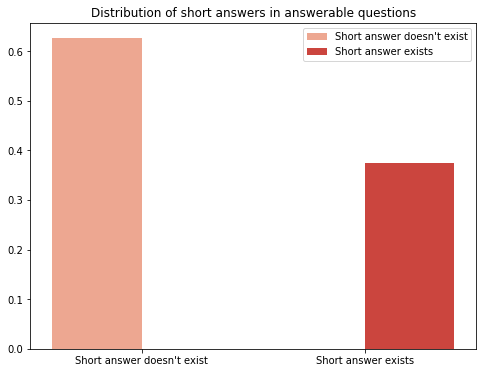

In [33]:
#checking the distribution of short answers
short_dist = df[df_ans_exists].short.apply(lambda x: "Short answer exists" if len(x) > 0 else "Short answer doesn't exist").value_counts(normalize=True)
plt.figure(figsize=(8,6))
sns.barplot(x=short_dist.index,y=short_dist.values,hue=short_dist.index,palette = "Reds").set_title("Distribution of short answers in answerable questions")

Text(0.5, 1.0, 'Distribution of Number of Short Answers in answerable questions')

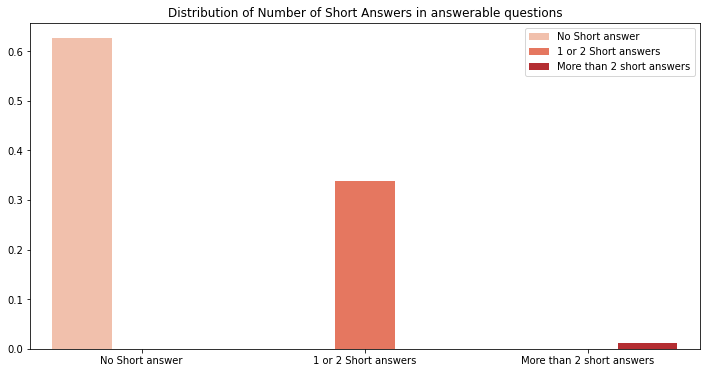

In [34]:
short_ans_dist = df[df_ans_exists].short.apply(len).value_counts(normalize=True)
short_ans_dist = pd.concat([short_ans_dist.loc[[0,1,],], pd.Series(short_ans_dist.loc[3:].sum(),index=['>=3'])])
short_ans_dist = short_ans_dist.rename(index={0: 'No Short answer',1:"1 or 2 Short answers",">=3":"More than 2 short answers"})
plt.figure(figsize=(12,6))
sns.barplot(x=short_ans_dist.index,y=short_ans_dist.values,hue=short_ans_dist.index,palette = "Reds").set_title("Distribution of Number of Short Answers in answerable questions")

In [35]:
#check if there are missing data in the datasets
def check_missing_data(df):
    missing_value=df.isna().sum().any()
    if missing_value==True:
        total = df.isnull().sum()
        percent = (df.isnull().sum())/(df.isnull().count()*100)
        output = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
        data_type = []

        for col in df.columns:
            dtype = str(train[col].dtype)
            data_type.append(dtype)
        output['Types'] = data_type
        return(np.transpose(output))
    else:
        return(False)
    
print("Missing data exists in train set: ",check_missing_data(train))
print("Missing data exists in test set: ",check_missing_data(test))

Missing data exists in train set:  False
Missing data exists in test set:  False


In [37]:
#check count values in each column
def count_values_in_column(data,feature):
    total=data.loc[:,feature].value_counts(dropna=False)
    percentage=round(data.loc[:,feature].value_counts(dropna=False,normalize=True)*100,2)
    return pd.concat([total,percentage],axis=1,keys=['Total','Percentage'])

In [38]:
count_values_in_column(df,'yes_no')

,Total,Percentage
NONE,1977,98.85
YES,17,0.85
NO,6,0.30


In [41]:
#count unique values in each column
def unique_values_in_column(data,feature):
    unique_val=pd.Series(data.loc[:,feature].unique())
    return pd.concat([unique_val],axis=1,keys=['Unique Values'])

In [42]:
unique_values_in_column(df,'document_text')

,Unique Values
0,Email marketing - Wikipedia <H1> Email marketi...
1,The Mother ( How I Met Your Mother ) - wikiped...
2,Human fertilization - wikipedia <H1> Human fer...
3,List of National Football League career quarte...
4,Roanoke Colony - wikipedia <H1> Roanoke Colony...
...,...
1987,Grace and Frankie - Wikipedia <H1> Grace and F...
1988,Cellular respiration - wikipedia <H1> Cellular...
1989,Some Like It Hot ( song ) - wikipedia <H1> Som...
1990,Princes in the Tower - wikipedia <H1> Princes ...


In [43]:
#find duplicated values in each column
def duplicated_values_data(data):
    dup=[]
    columns=data.columns
    for i in data.columns:
        dup.append(sum(data[i].duplicated()))
    return pd.concat([pd.Series(columns),pd.Series(dup)],axis=1,keys=['Columns','Duplicate count'])

In [44]:
duplicated_values_data(df)

,Columns,Duplicate count
0,document_text,8
1,long_answer_candidates,11
2,question_text,0
3,annotations,0
4,document_url,10
5,example_id,0
6,yes_no,1997
7,long,968
8,short,1283


In [45]:
df.describe()

,example_id
count,2.000000e+03
mean,-2.083664e+17
std,5.309581e+18
min,-9.209840e+18
25%,-4.901767e+18
50%,-2.302742e+17
75%,4.276727e+18
max,9.208620e+18


In [46]:
#remove hash texts in questions
def find_hash(text):
    line=re.findall(r'(?<=#)\w+',text)
    return " ".join(line)

In [47]:
df['hash']=df['question_text'].apply(lambda x: find_hash(x))

In [48]:
df['hash'].value_counts()

    2000
Name: hash, dtype: int64

In [49]:
unique_values_in_column(df,'hash').value_counts()

Unique Values
                 1
dtype: int64

In [50]:
# df['hash'] = df['hash'].fillna(df['document_text'])
df.loc[df['hash'].str.strip() == '', 'hash'] = df['document_text']

In [51]:
df

,document_text,long_answer_candidates,question_text,annotations,document_url,example_id,yes_no,long,short,hash
0,Email marketing - Wikipedia <H1> Email marketi...,"[{'start_token': 14, 'top_level': True, 'end_t...",which is the most common use of opt-in e-mail ...,"[{'yes_no_answer': 'NONE', 'long_answer': {'st...",https://en.wikipedia.org//w/index.php?title=Em...,5655493461695504401,NONE,"[1952, 2019]","[{'start_token': 1960, 'end_token': 1969}]",Email marketing - Wikipedia <H1> Email marketi...
1,The Mother ( How I Met Your Mother ) - wikiped...,"[{'start_token': 28, 'top_level': True, 'end_t...",how i.met your mother who is the mother,"[{'yes_no_answer': 'NONE', 'long_answer': {'st...",https://en.wikipedia.org//w/index.php?title=Th...,5328212470870865242,NONE,"[212, 310]","[{'start_token': 213, 'end_token': 215}]",The Mother ( How I Met Your Mother ) - wikiped...
2,Human fertilization - wikipedia <H1> Human fer...,"[{'start_token': 14, 'top_level': True, 'end_t...",what type of fertilisation takes place in humans,"[{'yes_no_answer': 'NONE', 'long_answer': {'st...",https://en.wikipedia.org//w/index.php?title=Hu...,4435104480114867852,NONE,"[319, 438]",[],Human fertilization - wikipedia <H1> Human fer...
3,List of National Football League career quarte...,"[{'start_token': 28, 'top_level': True, 'end_t...",who had the most wins in the nfl,"[{'yes_no_answer': 'NONE', 'long_answer': {'st...",https://en.wikipedia.org//w/index.php?title=Li...,5289242154789678439,NONE,"[509, 576]","[{'start_token': 512, 'end_token': 514}]",List of National Football League career quarte...
4,Roanoke Colony - wikipedia <H1> Roanoke Colony...,"[{'start_token': 32, 'top_level': True, 'end_t...",what happened to the lost settlement of roanoke,"[{'yes_no_answer': 'NONE', 'long_answer': {'st...",https://en.wikipedia.org//w/index.php?title=Ro...,5489863933082811018,NONE,"[-1, -1]",[],Roanoke Colony - wikipedia <H1> Roanoke Colony...
...,...,...,...,...,...,...,...,...,...,...
1995,Grace and Frankie - Wikipedia <H1> Grace and F...,"[{'start_token': 10, 'top_level': True, 'end_t...",how long is each grace and frankie episode,"[{'yes_no_answer': 'NONE', 'long_answer': {'st...",https://en.wikipedia.org//w/index.php?title=Gr...,-7716384782891686197,NONE,"[10, 399]","[{'start_token': 300, 'end_token': 304}]",Grace and Frankie - Wikipedia <H1> Grace and F...
1996,Cellular respiration - wikipedia <H1> Cellular...,"[{'start_token': 10, 'top_level': True, 'end_t...",after complete oxidation of a glucose molecule...,"[{'yes_no_answer': 'NONE', 'long_answer': {'st...",https://en.wikipedia.org//w/index.php?title=Ce...,8933277615800380148,NONE,"[780, 883]","[{'start_token': 796, 'end_token': 799}]",Cellular respiration - wikipedia <H1> Cellular...
1997,Some Like It Hot ( song ) - wikipedia <H1> Som...,"[{'start_token': 18, 'top_level': True, 'end_t...",who sings the song some like it hot,"[{'yes_no_answer': 'NONE', 'long_answer': {'st...",https://en.wikipedia.org//w/index.php?title=So...,-6909007989280228395,NONE,"[-1, -1]",[],Some Like It Hot ( song ) - wikipedia <H1> Som...
1998,Princes in the Tower - wikipedia <H1> Princes ...,"[{'start_token': 44, 'top_level': True, 'end_t...",who killed the twins in the tower of london,"[{'yes_no_answer': 'NONE', 'long_answer': {'st...",https://en.wikipedia.org//w/index.php?title=Pr...,1501574334625895729,NONE,"[-1, -1]",[],Princes in the Tower - wikipedia <H1> Princes ...


In [52]:
#remove punctuations
def find_punct(text):
    line = re.findall(r'[!"\$%&\'()*+,\-.\/:;=#@?\[\\\]^_`{|}~]*', text)
    string="".join(line)
    return list(string)

In [53]:
df['punctuation']=df['question_text'].apply(lambda x : find_punct(x))
df.loc[df['hash'].str.strip() == '', 'hash'] = df['question_text']

In [54]:
df

,document_text,long_answer_candidates,question_text,annotations,document_url,example_id,yes_no,long,short,hash,punctuation
0,Email marketing - Wikipedia <H1> Email marketi...,"[{'start_token': 14, 'top_level': True, 'end_t...",which is the most common use of opt-in e-mail ...,"[{'yes_no_answer': 'NONE', 'long_answer': {'st...",https://en.wikipedia.org//w/index.php?title=Em...,5655493461695504401,NONE,"[1952, 2019]","[{'start_token': 1960, 'end_token': 1969}]",Email marketing - Wikipedia <H1> Email marketi...,"[-, -]"
1,The Mother ( How I Met Your Mother ) - wikiped...,"[{'start_token': 28, 'top_level': True, 'end_t...",how i.met your mother who is the mother,"[{'yes_no_answer': 'NONE', 'long_answer': {'st...",https://en.wikipedia.org//w/index.php?title=Th...,5328212470870865242,NONE,"[212, 310]","[{'start_token': 213, 'end_token': 215}]",The Mother ( How I Met Your Mother ) - wikiped...,[.]
2,Human fertilization - wikipedia <H1> Human fer...,"[{'start_token': 14, 'top_level': True, 'end_t...",what type of fertilisation takes place in humans,"[{'yes_no_answer': 'NONE', 'long_answer': {'st...",https://en.wikipedia.org//w/index.php?title=Hu...,4435104480114867852,NONE,"[319, 438]",[],Human fertilization - wikipedia <H1> Human fer...,[]
3,List of National Football League career quarte...,"[{'start_token': 28, 'top_level': True, 'end_t...",who had the most wins in the nfl,"[{'yes_no_answer': 'NONE', 'long_answer': {'st...",https://en.wikipedia.org//w/index.php?title=Li...,5289242154789678439,NONE,"[509, 576]","[{'start_token': 512, 'end_token': 514}]",List of National Football League career quarte...,[]
4,Roanoke Colony - wikipedia <H1> Roanoke Colony...,"[{'start_token': 32, 'top_level': True, 'end_t...",what happened to the lost settlement of roanoke,"[{'yes_no_answer': 'NONE', 'long_answer': {'st...",https://en.wikipedia.org//w/index.php?title=Ro...,5489863933082811018,NONE,"[-1, -1]",[],Roanoke Colony - wikipedia <H1> Roanoke Colony...,[]
...,...,...,...,...,...,...,...,...,...,...,...
1995,Grace and Frankie - Wikipedia <H1> Grace and F...,"[{'start_token': 10, 'top_level': True, 'end_t...",how long is each grace and frankie episode,"[{'yes_no_answer': 'NONE', 'long_answer': {'st...",https://en.wikipedia.org//w/index.php?title=Gr...,-7716384782891686197,NONE,"[10, 399]","[{'start_token': 300, 'end_token': 304}]",Grace and Frankie - Wikipedia <H1> Grace and F...,[]
1996,Cellular respiration - wikipedia <H1> Cellular...,"[{'start_token': 10, 'top_level': True, 'end_t...",after complete oxidation of a glucose molecule...,"[{'yes_no_answer': 'NONE', 'long_answer': {'st...",https://en.wikipedia.org//w/index.php?title=Ce...,8933277615800380148,NONE,"[780, 883]","[{'start_token': 796, 'end_token': 799}]",Cellular respiration - wikipedia <H1> Cellular...,[]
1997,Some Like It Hot ( song ) - wikipedia <H1> Som...,"[{'start_token': 18, 'top_level': True, 'end_t...",who sings the song some like it hot,"[{'yes_no_answer': 'NONE', 'long_answer': {'st...",https://en.wikipedia.org//w/index.php?title=So...,-6909007989280228395,NONE,"[-1, -1]",[],Some Like It Hot ( song ) - wikipedia <H1> Som...,[]
1998,Princes in the Tower - wikipedia <H1> Princes ...,"[{'start_token': 44, 'top_level': True, 'end_t...",who killed the twins in the tower of london,"[{'yes_no_answer': 'NONE', 'long_answer': {'st...",https://en.wikipedia.org//w/index.php?title=Pr...,1501574334625895729,NONE,"[-1, -1]",[],Princes in the Tower - wikipedia <H1> Princes ...,[]


In [55]:
np.unique(df['punctuation'])

array([list([]), list(['&']), list(["'"]), list(["'", "'"]),
       list(['(', ')']), list(['(', ')', "'"]), list(['(', '.', ')']),
       list(['+']), list(['-']), list(['-', '(', ')']), list(['-', '-']),
       list(['-', '.', '.']), list(['.']),
       list(['.', '(', '&', ')', '(', ')']), list(['.', '.']),
       list(['.', '.', '-']), list(['/']), list(['='])], dtype=object)

In [56]:
# define training parameters 
num_train_ques = 2000
num_val_ques = 2050
sample_rate = 15

In [57]:
# define model parameters
epochs = 40
batch_size = 64
class_weights = {0: 0.5, 1: 5.}

# **Part 1- identifying correct long answer to a question**

In [58]:
def get_question_and_document(line):
    question = line['question_text']
    text = line['document_text'].split(' ')
    annotations = line['annotations'][0]    
    return question, text, annotations
                
def get_long_candidate(i, annotations, candidate):
    # check if this candidate is the correct long answer
    if i == annotations['long_answer']['candidate_index']:
        label = True
    else:
        label = False

    # get place where long answer starts and ends in the document text
    long_start = candidate['start_token']
    long_end = candidate['end_token']    
    return label, long_start, long_end

def form_data_row(question, label, text, long_start, long_end):
    row = {
        'question': question,
        'long_answer': ' '.join(text[long_start:long_end]),
        'is_long_answer': label,
    }    
    return row

In [59]:
def load_data(file_path, questions_start, questions_end):
    rows = []
    
    with open(file_path) as file:
        for i in tqdm(range(questions_start, questions_end)):
            line = file.readline()
            line = json.loads(line)
            question, text, annotations = get_question_and_document(line)

            for i, candidate in enumerate(line['long_answer_candidates']):
                label, long_start, long_end = get_long_candidate(i, annotations, candidate)

                if label == True or (i % sample_rate == 0):
                    rows.append(
                        form_data_row(question, label, text, long_start, long_end)
                    )        
    return pd.DataFrame(rows)

In [60]:
train_df = load_data(train_path, 0, num_train_ques)
test_df = load_data(train_path, num_train_ques, num_val_ques)

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

In [61]:
train_df.head(5)

,question,long_answer,is_long_answer
0,which is the most common use of opt-in e-mail ...,<Table> <Tr> <Td> </Td> <Td> ( hide ) This art...,False
1,which is the most common use of opt-in e-mail ...,<Tr> <Td> <Ul> <Li> Pay - per - click </Li> <L...,False
2,which is the most common use of opt-in e-mail ...,<P> Email marketing has evolved rapidly alongs...,False
3,which is the most common use of opt-in e-mail ...,<Li> Advertisers can reach substantial numbers...,False
4,which is the most common use of opt-in e-mail ...,<P> A common example of permission marketing i...,True


In [62]:
test_df.head(5)

,question,long_answer,is_long_answer
0,which is the most common use of opt-in e-mail ...,<Table> <Tr> <Td> </Td> <Td> ( hide ) This art...,False
1,which is the most common use of opt-in e-mail ...,<Tr> <Td> <Ul> <Li> Pay - per - click </Li> <L...,False
2,which is the most common use of opt-in e-mail ...,<P> Email marketing has evolved rapidly alongs...,False
3,which is the most common use of opt-in e-mail ...,<Li> Advertisers can reach substantial numbers...,False
4,which is the most common use of opt-in e-mail ...,<P> A common example of permission marketing i...,True


In [63]:
train_df.head(10)['long_answer']

0    <Table> <Tr> <Td> </Td> <Td> ( hide ) This art...
1    <Tr> <Td> <Ul> <Li> Pay - per - click </Li> <L...
2    <P> Email marketing has evolved rapidly alongs...
3    <Li> Advertisers can reach substantial numbers...
4    <P> A common example of permission marketing i...
5    <P> The CAN - SPAM Act of 2003 was passed by C...
6    <Table> <Tr> <Th_colspan="2"> Tracy McConnell ...
7    <P> Tracy McConnell , better known as `` The M...
8    <P> In `` Bass Player Wanted '' , the Mother p...
9    <Table> <Tr> <Td> Part of a series on </Td> </...
Name: long_answer, dtype: object

# **Pre-processing texts**

In [ ]:
#cleaning texts by removing stopwords 
def remove_stopwords(sentence):
    words = sentence.split()
    words = [word for word in words if word not in stopwords.words('english')]
    return ' '.join(words)

#removing html tags 
def remove_html(sentence):
    html = re.compile(r'<.*?>` `` ')
    return html.sub(r'', sentence)

#returns the pre-processed dataframe for long answers and questions
def preprocessed_df(df):
    df['long_answer'] = df['long_answer'].apply(lambda x : remove_stopwords(x))
    df['long_answer'] = df['long_answer'].apply(lambda x : remove_html(x))

    df['question'] = df['question'].apply(lambda x : remove_stopwords(x))
    df['question'] = df['question'].apply(lambda x : remove_html(x))
    
    return df

In [ ]:
#Count vectorizer for N grams

def ngrams_top(corpus,ngram_range,n=None):
    """
    List the top n words in a vocabulary according to occurrence in a text corpus.
    """
    vec = CountVectorizer(stop_words = 'english',ngram_range=ngram_range).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    total_list=words_freq[:n]
    df=pd.DataFrame(total_list,columns=['text','count'])
    return df

In [ ]:
ngrams_top(df['question_text'],(3,3),n=10)

In [ ]:
train_df = preprocessed_df(train_df)
test_df = preprocessed_df(test_df)
train_df.head(5)

In [ ]:
train_df['long_answer']

# Tokenizing the texts

In [71]:
# define tokenization parameters
filters = '!"''#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n'
lower_case = True
max_len = 500 #max lenght of a sentence input in to the model

In [72]:
#assigning a numeric index to each unique word in the dataset so that an array of integers
def define_tokenizer(series):
    sentences = pd.concat(series)    
    tokenizer = tf.keras.preprocessing.text.Tokenizer(lower=lower_case,filters=filters  )
    tokenizer.fit_on_texts(sentences)
    return tokenizer

#encoding, rest with 0 if max_len>no.of words in sentence 
def encode(sentences, tokenizer):
    encoded_sentences = tokenizer.texts_to_sequences(sentences)
    encoded_sentences = tf.keras.preprocessing.sequence.pad_sequences(encoded_sentences,
                                                                      maxlen=max_len, padding='post')
    return encoded_sentences

In [73]:
tokenizer = define_tokenizer([train_df.long_answer,train_df.question,
                              test_df.long_answer,test_df.question])

In [74]:
tokenizer

In [75]:
# Get the training data word index
word_index = tokenizer.word_index
print('Number of Unique Tokens: %d' % len(word_index))

Number of Unique Tokens: 67087


In [76]:
list(enumerate(word_index.items()))[:50]

[(0, ('td', 1)),
 (1, ('tr', 2)),
 (2, ('the', 3)),
 (3, ('li', 4)),
 (4, ('th', 5)),
 (5, ('of', 6)),
 (6, ('in', 7)),
 (7, ('and', 8)),
 (8, ('to', 9)),
 (9, ('a', 10)),
 (10, ('p', 11)),
 (11, ('ul', 12)),
 (12, ('2', 13)),
 (13, ('is', 14)),
 (14, ('colspan', 15)),
 (15, ("''", 16)),
 (16, ('by', 17)),
 (17, ('for', 18)),
 (18, ('who', 19)),
 (19, ('on', 20)),
 (20, ('table', 21)),
 (21, ('as', 22)),
 (22, ('was', 23)),
 (23, ('with', 24)),
 (24, ("'s", 25)),
 (25, ('1', 26)),
 (26, ('that', 27)),
 (27, ('when', 28)),
 (28, ('from', 29)),
 (29, ('it', 30)),
 (30, ('3', 31)),
 (31, ('are', 32)),
 (32, ('0', 33)),
 (33, ('this', 34)),
 (34, ('at', 35)),
 (35, ('what', 36)),
 (36, ('5', 37)),
 (37, ('or', 38)),
 (38, ('be', 39)),
 (39, ('new', 40)),
 (40, ('has', 41)),
 (41, ('an', 42)),
 (42, ('4', 43)),
 (43, ('his', 44)),
 (44, ('dd', 45)),
 (45, ('6', 46)),
 (46, ('most', 47)),
 (47, ('first', 48)),
 (48, ('not', 49)),
 (49, ('s', 50))]

In [77]:
tokenizer.word_index['handle']

5972

In [ ]:
tokenizer.word_index['pandemic']

In [79]:
train_long_answers = encode(train_df['long_answer'].values, tokenizer)
train_questions = encode(train_df['question'].values, tokenizer)

test_long_answers = encode(test_df['long_answer'].values, tokenizer)
test_questions = encode(test_df['question'].values, tokenizer)

In [80]:
train_long_answers

array([[  21,    2,    1, ...,    0,    0,    0],
       [   2,    1,   12, ...,    0,    0,    0],
       [  11, 4437, 2342, ...,    0,    0,    0],
       ...,
       [  21,    2,    1, ...,    0,    0,    0],
       [  11, 9614,    8, ...,    0,    0,    0],
       [  11, 8057, 2764, ...,    0,    0,    0]], dtype=int32)

In [81]:
train_long_answers[0]

array([  21,    2,    1,    1,    1, 1255,   34,  120,   41,  897,  873,
        268,  209,  351,   30,   38, 1236,  215,  873,   20,    3,  759,
        732,  253,   63,    8,   28,    9,  258,  215,  271, 2104,   21,
          2,    1,    1,    1,   34,  120,  442,  449,  255,   18,  663,
        268,  209,  351,   34,  120,   17,  474,  255,    9,  550,  374,
        587,  443,   80,   39,  595,    8,  460,  154,  119,  253,   63,
          8,   28,    9,  258,   34,  271,  287,    1,    2,   21,   21,
          2,    1,    1,    1,   34,  120, 2368, 1595,  138,  934,  268,
        351,   30,   17, 5660,    3, 1464,  144,    8,  474, 3287,  255,
       3154, 3058,  122,    6,  138,  934,  910,   39,  460,  150,   98,
        253,   63,    8,   28,    9,  258,   34,  271,  287,    1,    2,
         21,  253,   63,    8,   28,    9,  258,   34,  271,  287,    1,
          2,   21,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,   

In [82]:
train_questions

array([[52, 14,  3, ...,  0,  0,  0],
       [52, 14,  3, ...,  0,  0,  0],
       [52, 14,  3, ...,  0,  0,  0],
       ...,
       [36, 14,  3, ...,  0,  0,  0],
       [36, 14,  3, ...,  0,  0,  0],
       [36, 14,  3, ...,  0,  0,  0]], dtype=int32)

In [84]:
train_labels = train_df.is_long_answer.astype(int).values
test_labels = test_df.is_long_answer.astype(int).values

In [85]:
train_labels

array([0, 0, 0, ..., 0, 1, 0])

In [86]:
test_labels

array([0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

# Define embedding layer

 Loading the pre-trained embedding - using Glove

In [87]:
embed_size = 200
embedding_dict = {}

with open('../input/glove6b/glove.6B.' + str(embed_size) + 'd.txt','r') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vectors = np.asarray(values[1:],'float32')
        embedding_dict[word] = vectors        
f.close()

In [88]:
num_words = len(word_index) + 1

#initializing embedding matrix
embedding_matrix = np.zeros((num_words, embed_size))
print("num_words:", num_words)
print("embedding_matrix:", embedding_matrix)

num_words: 67088
embedding_matrix: [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [89]:
for word, i in word_index.items():
    if i > num_words:
        continue
    
    emb_vec = embedding_dict.get(word)
    
    if emb_vec is not None:
        embedding_matrix[i] = emb_vec

# Defining model¶

In [90]:
#initialize embedding layer
embedding_layer = tf.keras.layers.Embedding(
    len(word_index) + 1,
    embed_size,
    embeddings_initializer = tf.keras.initializers.Constant(embedding_matrix),
    trainable = False
)

In [92]:
# question encoding-encodes the question
question_input = Input(shape=(None,))
question_x = embedding_layer(question_input)
question_x = SpatialDropout1D(0.2)(question_x)
question_x = Bidirectional(LSTM(100, return_sequences=True))(question_x)
question_x = GlobalMaxPooling1D()(question_x) # outputs an encoded array representing the question

# answer encoding-encodes the answer
answer_input = Input(shape=(None,))
answer_x = embedding_layer(answer_input)
answer_x = SpatialDropout1D(0.2)(answer_x)
answer_x = Bidirectional(LSTM(150, return_sequences=True))(answer_x)
answer_x = GlobalMaxPooling1D()(answer_x) #outputs an encoded array representing the answer

# classification
combined_x = concatenate([question_x, answer_x])
combined_x = Dense(300, activation='relu')(combined_x)
combined_x = Dropout(0.5)(combined_x)
combined_x = Dense(300, activation='relu')(combined_x)
combined_x = Dropout(0.5)(combined_x)
model_output = Dense(1, activation='sigmoid')(combined_x) # probability how close the potential answer is to the true answer to the question.

# defining model by combining above three parts
model = tf.keras.models.Model(inputs=[answer_input, question_input], outputs=model_output)

In [93]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, None, 200)    13417600    input_4[0][0]                    
                                                                 input_5[0][0]                    
__________________________________________________________________________________________________
spatial_dropout1d_2 (SpatialDro (None, None, 200)    0           embedding[2][0]            

In [94]:
model.compile(
    loss='binary_crossentropy', 
    optimizer='adam',
    metrics=['BinaryAccuracy', 'Recall', 'Precision'])

In [95]:
#define callbacks - to avoid plateauing & achieve early stopping
callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', patience=2, verbose=1),
    tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5, verbose=1),]

In [ ]:
# define model parameters
epochs = 30
batch_size = 128
class_weights = {0: 0.5, 1: 5.}

In [ ]:
'''
history = model.fit(
    x = [train_long_answers, train_questions], 
    y = train_labels,
    validation_data = (
        [test_long_answers, test_questions], test_labels),
    epochs = epochs,
    callbacks = callbacks,
    class_weight = class_weights,
    batch_size = batch_size,
    shuffle = True
)
'''

In [ ]:
'''
# save model
model.save('long_model.h5')
'''

# Model evaluation

identifying if correct long answers given to a question

In [ ]:
'''
# Evaluate checking training & validation loss
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

ax[0].set_title('Training Loss')
ax[0].plot(history.history['loss'],marker = '.',mec = 'r', mfc = 'r')

ax[1].set_title('Validation Loss')
ax[1].plot(history.history['val_loss'],marker = '.',mec = 'r', mfc = 'r',color="green")
'''

In [ ]:
'''
# Evaluate checking accuracy, recall and precision
fig, ax = plt.subplots(3, 2, figsize=(15, 10))

ax[0,0].set_title('Training Accuracy')
ax[0,0].plot(history.history['binary_accuracy'],marker = '.',mec = 'r', mfc = 'r')

ax[0,1].set_title('Validation Accuracy')
ax[0,1].plot(history.history['val_binary_accuracy'],marker = '.',mec = 'r', mfc = 'r',color="green")

ax[1,0].set_title('Training Recall')
ax[1,0].plot(history.history['recall'],marker = '.',mec = 'r', mfc = 'r')

ax[1,1].set_title('Validation Recall')
ax[1,1].plot(history.history['val_recall'],marker = '.',mec = 'r', mfc = 'r',color="green")

ax[2,0].set_title('Training Precision')
ax[2,0].plot(history.history['precision'],marker = '.',mec = 'r', mfc = 'r')

ax[2,1].set_title('Validation Precision')
ax[2,1].plot(history.history['val_precision'],marker = '.',mec = 'r', mfc = 'r',color="green")
'''

In [ ]:
'''
# Evaluate checking recall

recall = history.history['recall'][-1]
precision = history.history['precision'][-1]

print('Train F1 score: {0:.4f}'.format(
    2 * (precision * recall) / (precision + recall)
))

recall = history.history['val_recall'][-1]
precision = history.history['val_precision'][-1]

print('Validation F1 score: {0:.4f}'.format(2 * (precision * recall) / (precision + recall)))
'''

In [ ]:
# predictions = model.predict([np.expand_dims(test_labels, axis=0), np.expand_dims(test_labels, axis=0)])

In [ ]:
# predictions

In [ ]:
# evaluating with live inputs
def test_question(question, positive, negative):
    sentences = [question, positive, negative]
    
    for i in range(3):
        sentences[i] = remove_stopwords(sentences[i])
        sentences[i] = remove_html(sentences[i])
    
    sentences = encode(sentences, tokenizer)
    
    predictions = model.predict([np.expand_dims(sentences[1], axis=0), np.expand_dims(sentences[0], axis=0)])

    print('Positive: {0:.2f}'.format(predictions[0][0]))

    predictions = model.predict(
        [np.expand_dims(sentences[2], axis=0), np.expand_dims(sentences[0], axis=0)])

    print('Negative: {0:.2f}'.format(predictions[0][0]))
    return predictions

In [ ]:
question = 'who invented a portable handset '

positive='<P> Martin Cooper invented a portable handset in 1973, when he was a project manager at Motorola. It was almost three decades after the idea of cellular communications was introduced by Bell Laboratories. </P>'
negative = '<P> Email marketing has evolved rapidly alongside the technological growth of the 21st century . Prior to this growth , when emails were novelties to the majority of customers , email marketing was not as effective . In 1978 , Gary Thuerk of Digital Equipment Corporation ( DEC ) sent out the first mass email to approximately 400 potential clients via the Advanced Research Projects Agency Network ( ARPANET ) . This email resulted in $13 million worth of sales in DEC products , and highlighted the potential of marketing through mass emails . However , as email marketing developed as an effective means of direct communication , users began blocking out content from emails with filters and blocking programs . In order to effectively communicate a message through email , marketers had to develop a way of pushing content through to the end user , without being cut out by automatic filters and spam removing software . This resulted in the birth of triggered marketing emails , which are sent to specific users based on their tracked online browsing patterns . </P>'

In [ ]:
# test_question(question, positive, negative)

In [ ]:
question = 'who is the south african high commissioner in london'

positive = "<P> Tracy McConnell , better known as `` The Mother '' , is the title character from the CBS television sitcom How I Met Your Mother . The show , narrated by Future Ted , tells the story of how Ted Mosby met The Mother . Tracy McConnell appears in 8 episodes from `` Lucky Penny '' to `` The Time Travelers '' as an unseen character ; she was first seen fully in `` Something New '' and was promoted to a main character in season 9 . The Mother is played by Cristin Milioti . </P>"

negative = "<P> In `` Bass Player Wanted '' , the Mother picks up a hitchhiking Marshall , carrying his son Marvin , on her way to Farhampton Inn . On their way , it is revealed that the Mother is a bass player in the band , that is scheduled to play at the wedding reception . But the band 's leader , Darren , forced her to quit . The Mother ultimately decides to confront Darren and retake the band . She ends up alone at the bar , and while practicing a speech to give Darren , Darren walks up to her furious the groom 's best man punched him for `` no reason . '' Amused by this , the Mother laughs , and Darren quits the band in anger . </P>"

In [ ]:
# test_question(question, positive, negative)

# **Part 2- extracting short answer from a long answer**

In [ ]:
#filter records where short answers exists
def get_short_answer(annotations, long_start, long_end):
    if len(annotations['short_answers']) > 0:
        short_start = annotations['short_answers'][0]['start_token']
        short_end = annotations['short_answers'][0]['end_token']        
        short_start = short_start - long_start
        short_end = short_end - long_start        
        return short_start, short_end
    else:
        return 0, 0
    
def form_short_data_row(question, text, long_start, long_end, short_start, short_end):
    long_answer = ' '.join(text[long_start:long_end])
    short_answer = ' '.join(long_answer.split(' ')[short_start:short_end])
    row = {
        'question': question,
        'long_answer': long_answer,
        'short_answer': short_answer,
        'short_start': short_start,
        'short_end': short_end
    }    
    return row

In [ ]:
#loading short answers
def load_short_data(file_path, questions_start, questions_end):
    rows = []    
    with open(file_path) as file:

        for i in tqdm(range(questions_start, questions_end)):
            line = file.readline()
            line = json.loads(line)
            question, text, annotations = get_question_and_document(line)

            for i, candidate in enumerate(line['long_answer_candidates']):
                label, long_start, long_end = get_long_candidate(i, annotations, candidate)

                if label == True:
                    short_start, short_end = get_short_answer(annotations, long_start, long_end)
                    
                    rows.append(
                        form_short_data_row(question, text, long_start, long_end, short_start, short_end)
                    )
        
    return pd.DataFrame(rows)

In [ ]:
# train_short_df = load_short_data(train_path, 0, num_train_ques)
# test_short_df = load_short_data(train_path, num_train_ques, num_val_ques)

In [ ]:
train_short_df.head(10)

In [ ]:
count_values_in_column(train_short_df,'short_answer')

In [ ]:
train_long_answers = encode(train_short_df['long_answer'].values, tokenizer)
train_questions = encode(train_short_df['question'].values, tokenizer)

test_long_answers = encode(test_short_df['long_answer'].values, tokenizer)
test_questions = encode(test_short_df['question'].values, tokenizer)

In [ ]:
#define 2 arrays for the start index and another for the end index
def form_short_labels(df, sentence_length):
    start_labels = np.zeros((len(df), sentence_length))
    end_labels = np.zeros((len(df), sentence_length))

    #get the token indexes from short_start and short_end columns and assign it to new arrays. encoding with 1
    for i in range(len(df)):
        start = df.loc[i].short_start
        end = df.loc[i].short_end

        if start < 500 and end < 500:
            start_labels[i, start] = 1
            end_labels[i, end] = 1
        else:
            continue
    
    return start_labels, end_labels

train_start_labels, train_end_labels = form_short_labels(train_short_df, max_len)
test_start_labels, test_end_labels = form_short_labels(test_short_df, max_len)

In [ ]:
print(train_short_df.loc[10].question)

print(train_short_df.loc[10].long_answer)
print(train_short_df.loc[10].short_answer)

print('Start index: {0}'.format(train_start_labels[10]))
print('End index: {0}'.format(train_end_labels[10]))

Defining the short model

In [ ]:
# short answer model parameters
short_epochs = 100
short_batch_size = 64
embed_size_short=200

In [ ]:
# load from file
embedding_dict = {}

with open('../input/glove6b/glove.6B.200' + 'd.txt','r') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vectors = np.asarray(values[1:],'float32')
        embedding_dict[word] = vectors
        
f.close()

# write to matrix
num_words = len(tokenizer.word_index) + 1
embedding_matrix = np.zeros((num_words, embed_size_short))

for word, i in tokenizer.word_index.items():
    if i > num_words:
        continue
    
    emb_vec = embedding_dict.get(word)
    
    if emb_vec is not None:
        embedding_matrix[i] = emb_vec
        
# load as tensorflow embedding
#define embedding layer for the short model
embedding_layer2 = tf.keras.layers.Embedding(
    len(tokenizer.word_index) + 1,
    embed_size_short,
    embeddings_initializer = tf.keras.initializers.Constant(embedding_matrix),
    trainable = False
)

In [ ]:
# encoding question input
question_input = Input(shape=(None,))
question_x = embedding_layer2(question_input)
question_x = SpatialDropout1D(0.2)(question_x)
question_x = Bidirectional(LSTM(200, return_sequences=True))(question_x)
question_x = Bidirectional(LSTM(100, return_sequences=True))(question_x)

# encoding answer input
answer_input = Input(shape=(None,))
answer_x = embedding_layer2(answer_input)
answer_x = SpatialDropout1D(0.2)(answer_x)
answer_x = Bidirectional(LSTM(250, return_sequences=True))(answer_x)
answer_x = Bidirectional(LSTM(150, return_sequences=True))(answer_x)

# merge the encodings
combined_x = concatenate([question_x, answer_x])

# predict start index of the short answer
start_x = Dropout(0.1)(combined_x) 
start_x = Conv1D(1,1)(start_x)
start_x = Flatten()(start_x)
start_x = Activation('softmax', name='start_token')(start_x)

# predict end index of the short answer
end_x = Dropout(0.1)(combined_x) 
end_x = Conv1D(1,1)(end_x)
end_x = Flatten()(end_x)
end_x = Activation('softmax', name='end_token')(end_x)

# merge the parts into one model
short_model = tf.keras.models.Model(inputs=[answer_input, question_input], outputs=[start_x, end_x])

In [ ]:
short_model.compile(
    loss='categorical_crossentropy', 
    optimizer='adam',
    metrics=['categorical_accuracy', 'Recall', 'Precision'])

In [ ]:
short_model.summary()

In [ ]:
# define callbacks for the short model
#increased patience or number of epochs with no improvement after which training will be stopped.
callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', patience=4, verbose=1),
    tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5, verbose=1),]

In [ ]:
history = short_model.fit(
    x = [train_long_answers, train_questions], 
    y = [train_start_labels, train_end_labels],epochs = short_epochs, callbacks = callbacks,
    validation_data = ([test_long_answers, test_questions], [test_start_labels, test_end_labels]),
    batch_size = short_batch_size,  shuffle = True)

In [ ]:
short_model.save('short_model.h5')

# **Model Evaluation**

identifying if correct short answers given to a long answers

In [ ]:
print('Epoch: {0}'.format(len(history.history['loss'])))
print('Loss: {0}'.format(history.history['loss'][-1]))

In [ ]:
print('Training final results')

accuracy = history.history['start_token_categorical_accuracy'][-1]
recall = history.history['start_token_recall'][-1]
precision = history.history['start_token_precision'][-1]

print('--------------------------------------------------')
print('Start token accuracy: {0}'.format(accuracy))
print('Start token recall: {0}'.format(recall))
print('Start token precision: {0}'.format(precision))
print('Start token F1 score: {0:.4f}'.format(2 * (precision * recall) / (precision + recall)))

print('--------------------------------------------------')

accuracy = history.history['end_token_categorical_accuracy'][-1]
recall = history.history['end_token_recall_1'][-1]
precision = history.history['end_token_precision_1'][-1]

print('End token accuracy: {0}'.format(accuracy))
print('End token recall: {0}'.format(recall))
print('End token precision: {0}'.format(precision))
print('End token F1 score: {0:.4f}'.format(2 * (precision * recall) / (precision + recall)))

In [ ]:
print('Validation final results')
print('--------------------------------------------------')

accuracy = history.history['val_start_token_categorical_accuracy'][-1]
recall = history.history['val_start_token_recall'][-1]
precision = history.history['val_start_token_precision'][-1]

print('Start token accuracy: {0}'.format(accuracy))
print('Start token recall: {0}'.format(recall))
print('Start token precision: {0}'.format(precision))
print('Start token F1 score: {0:.4f}'.format( 2 * (precision * recall) / (precision + recall)))

print('--------------------------------------------------')

accuracy = history.history['val_end_token_categorical_accuracy'][-1]
recall = history.history['val_end_token_recall_1'][-1]
precision = history.history['val_end_token_precision_1'][-1]

print('End token accuracy: {0}'.format(accuracy))
print('End token recall: {0}'.format(recall))
print('End token precision: {0}'.format(precision))
print('End token F1 score: {0:.4f}'.format(2 * (precision * recall) / (precision + recall)))

In [ ]:
#Evaluate plotting training & validation loss

fig, ax = plt.subplots(1, 2, figsize=(15, 5))

ax[0].set_title('Training Loss')
ax[0].plot(history.history['loss'],marker = '.',mec = 'r', mfc = 'r')

ax[1].set_title('Validation Loss')
ax[1].plot(history.history['val_loss'],marker = '.',mec = 'r', mfc = 'r',color="green")

In [ ]:
#plotting metrics; accuracy, precision, recall for the first output array
fig, ax = plt.subplots(3, 2, figsize=(15, 10))

fig.suptitle('First output-start token')

ax[0,0].set_title('Training Accuracy')
ax[0,0].plot(history.history['start_token_categorical_accuracy'],marker = '.',mec = 'r', mfc = 'r')

ax[0,1].set_title('Validation Accuracy')
ax[0,1].plot(history.history['val_start_token_categorical_accuracy'],marker = '.',mec = 'r', mfc = 'r',color="green")

ax[1,0].set_title('Training Recall')
ax[1,0].plot(history.history['start_token_recall'],marker = '.',mec = 'r', mfc = 'r')

ax[1,1].set_title('Validation Recall')
ax[1,1].plot(history.history['val_start_token_recall'],marker = '.',mec = 'r', mfc = 'r',color="green")

ax[2,0].set_title('Training Precision')
ax[2,0].plot(history.history['start_token_precision'],marker = '.',mec = 'r', mfc = 'r')

ax[2,1].set_title('Validation Precision')
ax[2,1].plot(history.history['val_start_token_precision'],marker = '.',mec = 'r', mfc = 'r',color="green")

In [ ]:
#plotting metrics; accuracy, precision, recall for the second output array
fig, ax = plt.subplots(3, 2, figsize=(15, 10))

fig.suptitle('Second output-end token')

ax[0,0].set_title('Training Accuracy')
ax[0,0].plot(history.history['end_token_categorical_accuracy'],marker = '.',mec = 'r', mfc = 'r')

ax[0,1].set_title('Validation Accuracy')
ax[0,1].plot(history.history['val_end_token_categorical_accuracy'],marker = '.',mec = 'r', mfc = 'r',color="green")

ax[1,0].set_title('Training Recall')
ax[1,0].plot(history.history['end_token_recall_1'],marker = '.',mec = 'r', mfc = 'r')

ax[1,1].set_title('Validation Recall')
ax[1,1].plot(history.history['val_end_token_recall_1'],marker = '.',mec = 'r', mfc = 'r',color="green")

ax[2,0].set_title('Training Precision')
ax[2,0].plot(history.history['end_token_precision_1'],marker = '.',mec = 'r', mfc = 'r')

ax[2,1].set_title('Validation Precision')
ax[2,1].plot(history.history['val_end_token_precision_1'],marker = '.',mec = 'r', mfc = 'r',color="green")

In [ ]:
#testing with live inputs
def test_short_answer(question, long_answer):
    sentences = [long_answer, question]
    
    sentences = encode(sentences, tokenizer)
    
    predictions = short_model.predict(
        [np.expand_dims(sentences[0], axis=0), np.expand_dims(sentences[1], axis=0)])
    
    predictions = np.array(predictions)
    
    prediction_start = np.argmax(predictions[0,0])
    prediction_end = np.argmax(predictions[1,0])
    prediction_string = ' '.join(long_answer.split(' ')[prediction_start:prediction_end])

    return prediction_start, prediction_end, prediction_string

In [ ]:
question = 'which is the most common use of opt-in e-mail marketing'
long_answer = "<P> A common example of permission marketing is a newsletter sent to an advertising firm 's customers . Such newsletters inform customers of upcoming events or promotions , or new products . In this type of advertising , a company that wants to send a newsletter to their customers may ask them at the point of purchase if they would like to receive the newsletter . </P>"

In [ ]:
start, end, short_answer = test_short_answer(question, long_answer)

print('Start token: ' + str(start))
print('End token: ' + str(end))
print('Answer: ' + short_answer)

In [ ]:
question = 'who invented a portable handset'
long_answer="<P> Martin Cooper invented a portable handset in 1973, when he was a project manager at Motorola. It was almost three decades after the idea of cellular communications was introduced by Bell Laboratories. </P>"

In [ ]:
start, end, short_answer = test_short_answer(question, long_answer)

print('Start token: ' + str(start))
print('End token: ' + str(end))
print('Answer: ' + short_answer)

In [ ]:
question = 'who is the south african high commissioner in london'
long_answer = "<P> Tracy McConnell , better known as `` The Mother '' , is the title character from the CBS television sitcom How I Met Your Mother . The show , narrated by Future Ted , tells the story of how Ted Mosby met The Mother . Tracy McConnell appears in 8 episodes from `` Lucky Penny '' to `` The Time Travelers '' as an unseen character ; she was first seen fully in `` Something New '' and was promoted to a main character in season 9 . The Mother is played by Cristin Milioti . </P>"

In [ ]:
start, end, short_answer = test_short_answer(question, long_answer)

print('Start token: ' + str(start))
print('End token: ' + str(end))
print('Answer: ' + short_answer)

# **Horizontal and Vertical Ensembles**

In [104]:
import os
os.chdir(r'/kaggle/working')

In [124]:
def assemble_horizontal_ensemble(ensemble_size, min_val_loss, filepath, epochs, batch_size, class_weights):
    callbacks = [
        tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', patience=2, verbose=1),
        tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5, verbose=1),
        tf.keras.callbacks.ModelCheckpoint(
            filepath=filepath,
            save_weights_only=True,
            monitor='val_accuracy',
            mode='min',
            save_freq='epoch',
            initial_value_threshold=min_val_loss
        )
    ]

    # Save the model weight files after each epoch
    model.fit(
        x = [train_long_answers, train_questions], 
        y = train_labels,
        validation_data = (
            [test_long_answers, test_questions], test_labels),
        epochs = epochs,
        callbacks = callbacks,
        class_weight = class_weights,
        batch_size = batch_size,
        shuffle = True
    )

In [ ]:
# Filter out just the last {ensemble_size} number of models and removed the previous ones
# Keep the file names of the last {ensemble_size} models in a list
def filter_old_epoch_files(directory_name, file_extension = "hdf5"):
    horizontal_ensemble = []
    files = sorted(os.listdir(directory_name), reverse=True)
    epoch_nums_to_remove = epochs - ensemble_size

    for file in files:
        if "." in file:
            file_ext = file.split(".")[-1]
            if file_ext == "hdf5":
                epoch, val_loss = file.split("_")
                epoch = int(epoch)
                # This keeps just the last {ensemble_size} models
                if epoch < epoch_nums_to_remove:
                    os.remove(file)
                else:
                    horizontal_ensemble.append(file)
                    
    return horizontal_ensemble

In [144]:
def create_model():
    #initialize embedding layer
    embedding_layer = tf.keras.layers.Embedding(
        len(word_index) + 1,
        embed_size,
        embeddings_initializer = tf.keras.initializers.Constant(embedding_matrix),
        trainable = False
    )
    
    # question encoding-encodes the question
    question_input = Input(shape=(None,))
    question_x = embedding_layer(question_input)
    question_x = SpatialDropout1D(0.2)(question_x)
    question_x = Bidirectional(LSTM(100, return_sequences=True))(question_x)
    question_x = GlobalMaxPooling1D()(question_x) # outputs an encoded array representing the question

    # answer encoding-encodes the answer
    answer_input = Input(shape=(None,))
    answer_x = embedding_layer(answer_input)
    answer_x = SpatialDropout1D(0.2)(answer_x)
    answer_x = Bidirectional(LSTM(150, return_sequences=True))(answer_x)
    answer_x = GlobalMaxPooling1D()(answer_x) #outputs an encoded array representing the answer

    # classification
    combined_x = concatenate([question_x, answer_x])
    combined_x = Dense(300, activation='relu')(combined_x)
    combined_x = Dropout(0.5)(combined_x)
    combined_x = Dense(300, activation='relu')(combined_x)
    combined_x = Dropout(0.5)(combined_x)
    model_output = Dense(1, activation='sigmoid')(combined_x) # probability how close the potential answer is to the true answer to the question.

    # defining model by combining above three parts
    model = tf.keras.models.Model(inputs=[answer_input, question_input], outputs=model_output)
    
    model.compile(
        loss='binary_crossentropy', 
        optimizer='adam',
        metrics=['BinaryAccuracy', 'Recall', 'Precision'])

    return model

In [125]:
# define horizontal ensemble parameters
ensemble_size = 10
min_val_loss = 0.02
filepath = "{epoch:02d}_{val_loss:.2f}.hdf5"
directory_name = r'/kaggle/working'

# define model parameters
epochs = 30
batch_size = 128
class_weights = {0: 0.5, 1: 5.}

In [126]:
assemble_horizontal_ensemble(ensemble_size, min_val_loss, filepath, epochs, batch_size, class_weights)

Epoch 1/30
157/157 [==============================] - 30s 192ms/step - loss: 0.1176 - binary_accuracy: 0.9318 - recall: 0.9335 - precision: 0.4284 - val_loss: 0.1904 - val_binary_accuracy: 0.9069 - val_recall: 1.0000 - val_precision: 0.4000
Epoch 2/30
157/157 [==============================] - 30s 192ms/step - loss: 0.1089 - binary_accuracy: 0.9395 - recall: 0.9461 - precision: 0.4600 - val_loss: 0.1094 - val_binary_accuracy: 0.9403 - val_recall: 1.0000 - val_precision: 0.5098
Epoch 3/30
157/157 [==============================] - 30s 192ms/step - loss: 0.0960 - binary_accuracy: 0.9488 - recall: 0.9576 - precision: 0.5038 - val_loss: 0.1149 - val_binary_accuracy: 0.9356 - val_recall: 1.0000 - val_precision: 0.4906
Epoch 4/30
157/157 [==============================] - 30s 192ms/step - loss: 0.0900 - binary_accuracy: 0.9515 - recall: 0.9518 - precision: 0.5184 - val_loss: 0.0688 - val_binary_accuracy: 0.9618 - val_recall: 1.0000 - val_precision: 0.6190
Epoch 5/30
157/157 [================

In [130]:
horizontal_ensemble = filter_old_epoch_files(directory_name)
horizontal_ensemble

['30_0.00.hdf5',
 '29_0.00.hdf5',
 '28_0.00.hdf5',
 '27_0.00.hdf5',
 '26_0.00.hdf5',
 '25_0.01.hdf5',
 '24_0.00.hdf5',
 '23_0.00.hdf5',
 '22_0.00.hdf5',
 '21_0.01.hdf5',
 '20_0.00.hdf5']

In [146]:
for model_weights in horizontal_ensemble:
    model = create_model()
    model.load_weights(f'{directory_name}/{model_weights}')
    model.summary()
    print('model', f'{directory_name}/{model_weights}')

Model: "model_13"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_28 (InputLayer)           [(None, None)]       0                                            
__________________________________________________________________________________________________
input_29 (InputLayer)           [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding_12 (Embedding)        (None, None, 200)    13417600    input_28[0][0]                   
                                                                 input_29[0][0]                   
__________________________________________________________________________________________________
spatial_dropout1d_26 (SpatialDr (None, None, 200)    0           embedding_12[0][0]        

KeyboardInterrupt: 